In [23]:
# Importando as libs que iremos usar
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## DATASET
- Importando o dataset que iremos usar

In [24]:
# Dataset Iris
from sklearn.datasets import load_iris

# Carrega o Dataset
input_data = load_iris()

print(f"Base de dados com {len(input_data['data'])} linhas")

Base de dados com 150 linhas


- Separa os dados e as labels

In [25]:
# Principio do Aprendizado de Maquina Supervisionado
data = input_data['data']
labels = input_data['target']

- Dividindo dados para o processo de *treino*, *teste* e *validação*

In [26]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels,
                                                                    test_size=0.2, 
                                                                    random_state=41)

data_train, data_validation, labels_train, labels_validation = train_test_split(data_train, labels_train,
                                                                                test_size=0.1,
                                                                                random_state=1)

print(f'Quantidade de Dados para Treinamento : {len(data_train)}')
print(f'Quantidade de Dados para Validação : {len(data_test)}')
print(f'Quantidade de Dados para Teste : {len(data_validation)}')

Quantidade de Dados para Treinamento : 108
Quantidade de Dados para Validação : 30
Quantidade de Dados para Teste : 12


In [27]:
# Construindo a classe que será usada pelo Torch para acessar o dataset
class DataSet(torch.utils.data.Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

In [28]:
# Carregando nossos datasets de treino, teste e validação
dataset = DataSet(data_train,labels_train)
data_train = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

dataset = DataSet(data_validation,labels_validation)
data_validation = DataLoader(dataset, batch_size=len(data_validation), shuffle=True, num_workers=0)

dataset = DataSet(data_test,labels_test)
data_test = DataLoader(dataset, batch_size=len(data_test), shuffle=True, num_workers=0)

## Modelo de Rede
- 4 Entradas (4 Caracteristicas da Flor)
- 2 CAMADAS de Neuronios ocultos
- 3 Saídas (3 Rotulos de Flor)

In [29]:
class IrisClassifier(nn.Module) :
    def __init__(self, input_size = 4, 
                 hidden_size1=20, 
                 hidden_size2 = 10, 
                 output_size = 3) :
        
        super().__init__()
        # Camada de entrada --> Primeira camada oculta
        self.fc1 = nn.Linear(input_size, hidden_size1)
        # Primeira camada oculta --> Segunda camada oculta
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # Segunda camada oculta --> Camada de saída
        self.output = nn.Linear(hidden_size2, output_size)
        # Função de ativação
        self.relu = nn.ReLU()

    # Fluxo dos dados da entrada para saída
    def forward(self, data) :
        data = self.relu(self.fc1(data))
        data = self.relu(self.fc2(data))
        data = self.output(data)
        return data

## Instanciando e configurando a rede

In [30]:
net = IrisClassifier()
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [31]:
# Processo de treino
def train_one_epoch(model,loss_function,optimizer,data_train):
    model.train()
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_train):
        x,y = data
        x = x.to(torch.float)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_function(output,y)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)
    return current_loss/(i+1), current_accuracy/total_samples

In [32]:
# Processo de validação
def validation_one_epoch(model,loss_function, data_validation):
    model.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0
    for i,data in enumerate(data_validation):
        x,y = data
        x = x.to(torch.float)
        output = model(x)
        loss = loss_function(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)
    return current_loss/(i+1), current_accuracy/total_samples

## Executando

In [33]:
epochs = 1000
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []
best_val_loss = 1e9

for epoch in range(epochs):

    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(net,criterion,optimizer,data_train)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(net,criterion, data_validation)

    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    # Salva o melhor modelo
    if val_loss_per_epoch < best_val_loss:
      best_val_loss = val_loss_per_epoch
      model_path = 'best_model_iris'
      torch.save(net.state_dict(),model_path)

    if(epoch % 1 == 0) :
      print(f'Epóca [: {epoch}]')
      print(f'Erro de Treinamento: {train_loss_per_epoch}')
      print(f'Erro de Validação: {val_loss_per_epoch}')
      print(f'Acurácia de Treinamento: {train_accuracy_per_epoch}')
      print(f'Acurácia de Validação: {val_accuracy_per_epoch}')
      print()

Epóca [: 0]
Erro de Treinamento: 1.000030279159546
Erro de Validação: 0.8973372578620911
Acurácia de Treinamento: 0.5185185074806213
Acurácia de Validação: 0.75

Epóca [: 1]
Erro de Treinamento: 0.8917091637849808
Erro de Validação: 0.8581444621086121
Acurácia de Treinamento: 0.6296296119689941
Acurácia de Validação: 0.5833333134651184

Epóca [: 2]
Erro de Treinamento: 0.7683506608009338
Erro de Validação: 0.7637781500816345
Acurácia de Treinamento: 0.6759259104728699
Acurácia de Validação: 0.5833333134651184

Epóca [: 3]
Erro de Treinamento: 0.6489832848310471
Erro de Validação: 0.6710866093635559
Acurácia de Treinamento: 0.6851851940155029
Acurácia de Validação: 0.5833333134651184

Epóca [: 4]
Erro de Treinamento: 0.5522543340921402
Erro de Validação: 0.6472484469413757
Acurácia de Treinamento: 0.6851851940155029
Acurácia de Validação: 0.5833333134651184

Epóca [: 5]
Erro de Treinamento: 0.5121466889977455
Erro de Validação: 0.5698402523994446
Acurácia de Treinamento: 0.6851851940155

## Métricas e resultados
- Plotando as curvas de perda para treino e validação

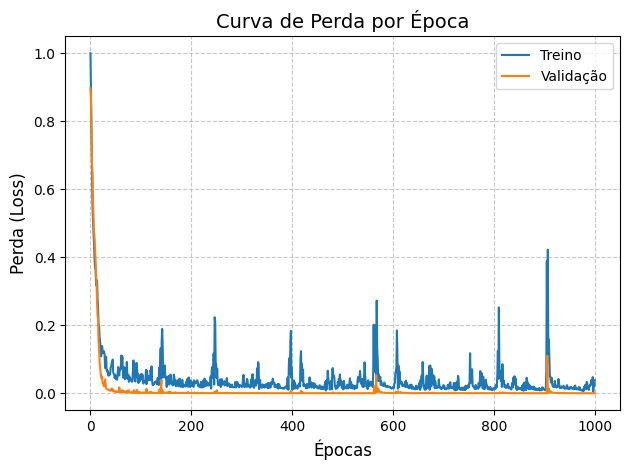

In [34]:
# Criando os graficos
plt.plot(train_loss_all_epoch, label='Treino')
plt.plot(val_loss_all_epoch, label='Validação')

# Adicionando título e rótulos aos eixos
plt.title('Curva de Perda por Época', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Perda (Loss)', fontsize=12)

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.grid(True, linestyle='--', alpha=0.7)  # Adicionando grade
plt.tight_layout()  # Ajuste para não cortar o gráfico
plt.show()

- Plotando as curvas de acuracia para treino e validação

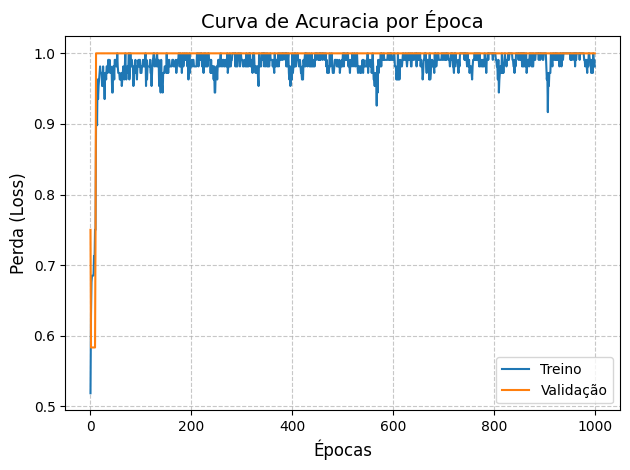

In [ ]:
# Criando os graficos
plt.plot(train_accuracy_all_epoch, label='Treino')
plt.plot(val_accuracy_all_epoch, label='Validação')

# Adicionando título e rótulos aos eixos
plt.title('Curva de Acurácia por Época', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Acurácia (accuracy)', fontsize=12)

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.grid(True, linestyle='--', alpha=0.7)  # Adicionando grade
plt.tight_layout()  # Ajuste para não cortar o gráfico
plt.show()

- Plotando a matriz de confusão

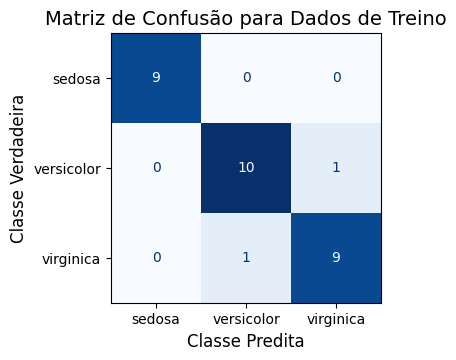

In [36]:
# Montando a matriz
net.train(False)
for data in data_test:
    x_test, y_test = data
    x_test = x_test.to(torch.float32)
    y_pred = net(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    cm = confusion_matrix(y_test, y_pred, labels=range(3))

# Exibindo a matriz de confusão graficamente
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sedosa', 'versicolor', 'virginica'])
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='Blues', colorbar=False)

# Melhorando o gráfico
ax.set_title('Matriz de Confusão para Dados de Treino', fontsize=14)
ax.set_xlabel('Classe Predita', fontsize=12)
ax.set_ylabel('Classe Verdadeira', fontsize=12)

plt.tight_layout()
plt.show()

- Exibindo métricas de Classificação

In [37]:
# Calculando e imprimindo o relatório de classificação
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.91      0.91      0.91        11
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.94        30
weighted avg       0.93      0.93      0.93        30

